In [92]:
import sys
sys.path.append("/home/huaqingj/MyResearch/AD_control_data/TVDN")

In [93]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
%matplotlib inline

In [94]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [95]:
os.chdir("/home/huaqingj/MyResearch/AD_control_data/TVDN")
resDir = Path("./results")
dataDir = Path("./data")

In [96]:
# ecpts
fil = list(resDir.glob("AD*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [97]:
# Eigvals
fil = list(resDir.glob("AD*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [98]:
fil = list(resDir.glob("AD*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [99]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [100]:
import pandas as pd
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv('./DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

**List of features** 

- Num of ecpts

- The mean dwell time (in second)

- Eigval with largest mode for the segment with the maximal dwell time

- EigVecs weighted by the eigvals for the segment with the maximal dwell time


In [101]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [102]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

In [103]:
fsBoth= fsAD + fsCtrl
fs1Idxs = [fs.ncpts!=0 for fs in fsBoth]

## Predction

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

### All data

In [105]:
fsAD[0].keys()

dict_keys(['ncpts', 'meanDwell', 'maxDwell', 'minDwell', 'maxEigVal', 'maxEigValMode', 'maxEigValReal', 'maxEigValImag', 'max2EigVal', 'max2EigValMode', 'max2EigValReal', 'max2EigValImag', 'maxwU', 'wUsumAll', 'wUmeanAll', 'maxwUraw', 'maxwUnorm', 'maxwUcorrs', 'maxwU2', 'maxwU2norm', 'maxU', 'maxUnorm', 'maxUMode', 'maxUReal', 'maxUImag', 'maxUcorrs', 'r'])

In [218]:
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [219]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
aucCs = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(stdXs):
        # adaptive lasso does not work
        #clfOrd = LogisticRegression(penalty="none", random_state=0, C=C, solver="lbfgs")
        #clfOrd.fit(stdXs[trIdxs, :], Ys[trIdxs])
        #ws = 1/ np.abs(clfOrd.coef_)
        #stdXsNew = stdXs/ws.reshape(1, -1)
        
        stdXsNew = stdXs
        clf = LogisticRegression(penalty="l1", random_state=0, C=C)
        clf.fit(stdXsNew[trIdxs, :], Ys[trIdxs])
        eProbs.append(clf.predict_proba(stdXsNew[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    aucCs.append(auc)

Text(0, 0.5, 'AUC')

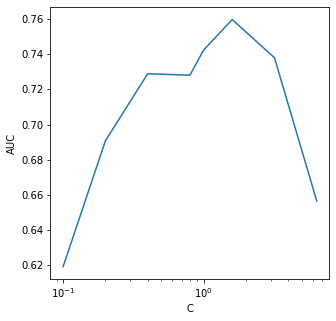

In [220]:
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [221]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(stdXs):
    #clf = GBC(n_estimators=50, random_state=0, max_depth=2, learning_rate=0.1)
    clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
    clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.7597402597402597


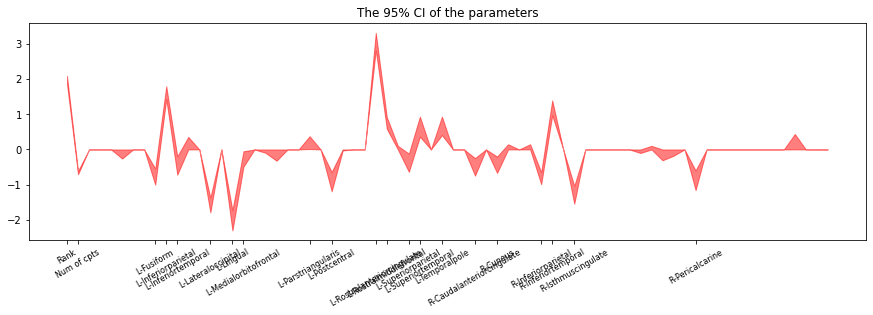

In [222]:
lows, ups = np.quantile(parass[:, :], [0.025, 0.975], axis=0)
kpidx = np.bitwise_or(lows >0,  ups < 0)
kpidxId = np.where(kpidx)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxId, xlabs[kpidxId], rotation=30, fontsize=8)
#plt.savefig("./plots/lassoSel.jpg", bbox_inches='tight')

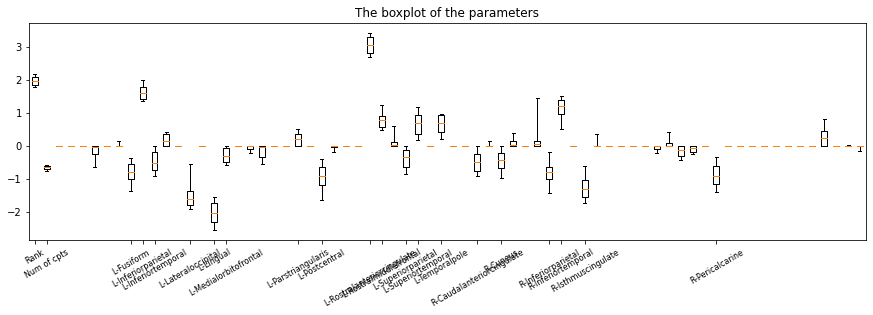

In [223]:
import matplotlib.cbook as cbook
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parass[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parass[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parass[:, idx]), np.min(parass[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxId, xlabs[kpidxId], rotation=30, fontsize=8)
#plt.savefig("./plots/lassoSel.jpg", bbox_inches='tight')

In [177]:
import statsmodels.api as sm
stdXsLasso = stdXs[:, kpidxId]
md = sm.Logit(Ys, stdXsLasso)
mdres = md.fit()
print(mdres.summary())

Optimization terminated successfully.
         Current function value: 0.335066
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                      135
Method:                           MLE   Df Model:                           22
Date:                Fri, 04 Feb 2022   Pseudo R-squ.:                  0.5120
Time:                        16:35:39   Log-Likelihood:                -52.941
converged:                       True   LL-Null:                       -108.49
Covariance Type:            nonrobust   LLR p-value:                 7.023e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1223      0.880      3.547      0.000       1.397       4.848
x2            -0.0934      0

In [178]:
xlabs[kpidxId][mdres.pvalues<=0.05]

array(['Rank', 'L-Fusiform', 'L-Lingual', 'L-Rostralanteriorcingulate',
       'L-Temporalpole', 'R-Isthmuscingulate'], dtype='<U26')

In [179]:
nobs = stdXs.shape[0]
Aucss = []
for j in range(1000):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")

The mean of AUC under 1000 repetitions is 0.771 and the standard deviation is 0.076.


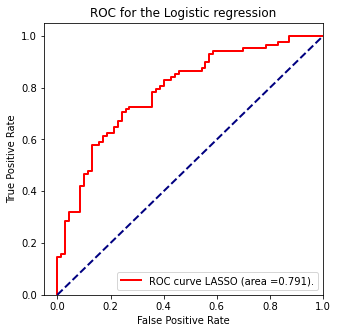

In [25]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve LASSO (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
#plt.savefig("./plots/roc.jpg", bbox_inches='tight')

In [226]:
l1_ratio = 0.1
penalty = "l2"
fsNameSet = [
             # ["r"], 
             # ["ncpts"], 
             # ["wUsumAll"], 
             # ["wUmeanAll"], 
             # ["ncpts", "wUsumAll"], 
             # ["ncpts", "wUmeanAll"], 
             # ["r", "wUsumAll"], 
             # ["r", "wUmeanAll"], 
             ["r", "ncpts", "wUsumAll"],  
             ["r", "ncpts", "wUmeanAll"], 
             ["r", "ncpts", "maxwU"]]
for fsName in fsNameSet:
    Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fsAD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fsAD])
            cfCtrl = np.array([fs[fName] for fs in fsCtrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(stdXs):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            #clf = LogisticRegression(penalty="elasticnet", random_state=0, C=C, solver="saga", l1_ratio=l1_ratio)
            clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
            eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(Ys, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
        
    optC = Cs[np.argmax(aucCs)]
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        #clf = LogisticRegression(penalty="elasticnet", random_state=0, C=optC, solver="saga", l1_ratio=l1_ratio)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        #clf = LogisticRegression(penalty="elasticnet", random_state=0, C=optC, solver="saga", l1_ratio=l1_ratio)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

Features are ['r', 'ncpts', 'wUsumAll'].
The AUC under optimal C is 0.791.
The mean of AUC under 1000 repetitions is 0.787 and the standard deviation is 0.074.
----------------------------------------------------------------------------------------------------
Features are ['r', 'ncpts', 'wUmeanAll'].
The AUC under optimal C is 0.790.
The mean of AUC under 1000 repetitions is 0.785 and the standard deviation is 0.079.
----------------------------------------------------------------------------------------------------
Features are ['r', 'ncpts', 'maxwU'].
The AUC under optimal C is 0.688.
The mean of AUC under 1000 repetitions is 0.688 and the standard deviation is 0.090.
----------------------------------------------------------------------------------------------------


### Switch between model I and II

In [27]:
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
#fsName = ["r", "maxwU"]
fsName = ["r", "ncpts", "maxwU", "maxwU2"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
Xs = Xs[fs1Idxs, :]
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

fsName = ["r", "ncpts", "maxwU"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXsPart = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [28]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
aucCs = []
for C in Cs:
    eProbs = []
    for tIdx in range(len(Ys)):
        clf = LogisticRegression(penalty="l1", random_state=0, C=C)
        curNcpt = fsBoth[tIdx].ncpts
        if curNcpt == 0:
            trYs = np.delete(Ys, tIdx, axis=0)
            trXs = np.delete(stdXsPart, tIdx, axis=0)
            teXs = stdXsPart[tIdx, :].reshape(1, -1)
        else:
            curKpIdx = fs1Idxs.copy()
            curKpIdx[tIdx] = False
            trYs = Ys[curKpIdx]
            
            trXs = stdXs[np.where(fs1Idxs)[0] != tIdx, :]
            teXs = stdXs[np.where(fs1Idxs)[0] == tIdx, :]
            
            
        clf.fit(trXs, trYs)
        eProbs.append(clf.predict_proba(teXs))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    aucCs.append(auc)
np.max(aucCs)

0.7625

Text(0, 0.5, 'AUC')

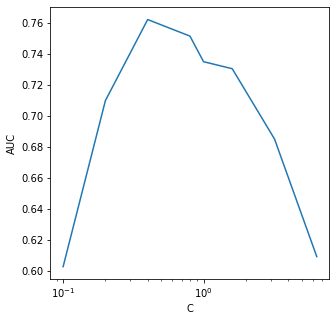

In [29]:
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [30]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
for tIdx in range(len(Ys)):
    clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
    curNcpt = fsBoth[tIdx].ncpts
    if curNcpt == 0:
        trYs = np.delete(Ys, tIdx, axis=0)
        trXs = np.delete(stdXsPart, tIdx, axis=0)
        teXs = stdXsPart[tIdx, :].reshape(1, -1)
    else:
        curKpIdx = fs1Idxs.copy()
        curKpIdx[tIdx] = False
        trYs = Ys[curKpIdx]
        
        trXs = stdXs[np.where(fs1Idxs)[0] != tIdx, :]
        teXs = stdXs[np.where(fs1Idxs)[0] == tIdx, :]
        
        
    clf.fit(trXs, trYs)
    eProbs.append(clf.predict_proba(teXs))
    
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
print(auc)

0.7625


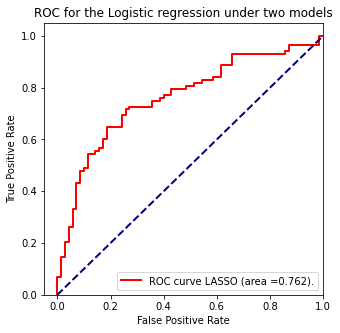

In [31]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve LASSO (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression under two models")
plt.legend(loc="lower right")
plt.savefig("./plots/rocComb.jpg", bbox_inches='tight')

In [32]:
from sklearn.metrics import f1_score

0.7522935779816513

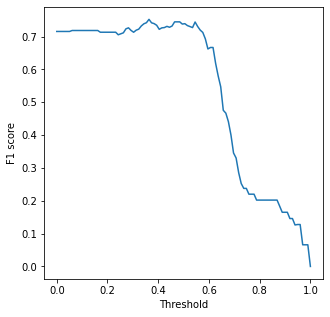

In [33]:
thres = np.linspace(0, 1, 100)
f1s = []
for thre in thres:
    f1s.append(f1_score(Ys, eProbs[:, 1]>thre))
    
plt.figure(figsize=[5, 5])
plt.plot(thres, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 score")

optThre = thres[np.argmax(f1s)]
#optThre = 0.5
f1_score(Ys, eProbs[:, 1]>optThre)